In [65]:
# Modèle 3 : LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data/df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

#plt.figure(figsize=(12, 6))
#plt.plot(ts)
#plt.title('Prix journaliers du S&P500')
#plt.show()

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

# GDPQ = pd.read_csv('GDP Quarter.csv',sep=',')
# GDPQ['date'] = pd.to_datetime(GDPQ['timestamp'])
# GDPQ['year'] = GDPQ['date'].dt.year
# GDPQ['month'] = GDPQ['date'].dt.month

# GDPQ_full = []
# for _, row in GDPQ.iterrows():
#     for m in range(row['date'].quarter * 3 - 2, row['date'].quarter * 3 + 1):
#         GDPQ_full.append({'year': row['year'], 'month': m, 'CroissQ': row['CroissQ']})
# GDPQ_full = pd.DataFrame(GDPQ_full)


data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
#data = data.merge(GDPQ, on=['year', 'month'], how='left')
#data.drop(['timestamp_x','date_y','timestamp_y', 'date'], axis=1, inplace=True)
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
data.rename(columns = {'date_x': 'date'}, inplace = True)
data.set_index('date', inplace=True)

data.columns = data.columns.str.lower()

[*********************100%***********************]  1 of 1 completed


In [66]:
data.head()
# data.columns
df = data.copy()

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split



# Paramètres
seq_len = 10  # Longueur de séquence temporelle

# Normalisation
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# Création des séquences
X, y = [], []
for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len, df.columns.get_loc('cible')])
X, y = np.array(X), np.array(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, df.shape[1])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Entraînement
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prédiction
predictions = model.predict(X_test)

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0672 - val_loss: 0.0047
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8306e-04 - val_loss: 0.0039
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5999e-04 - val_loss: 0.0016
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0676e-04 - val_loss: 9.9674e-04
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4526e-05 - val_loss: 0.0012
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3314e-05 - val_loss: 0.0011
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7052e-05 - val_loss: 0.0015
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1588e-05 - val_loss: 0.0015
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8136e-05 - val_loss: 0.0018
Epoch 10/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4400e-05 - val_loss: 0.0018
Epoch 11/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3675e-05 - val_loss: 0.00

MSE: 8607.0433
MAE: 72.1564
R²: 0.9884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Prochaine valeur prédite: 6719.1284


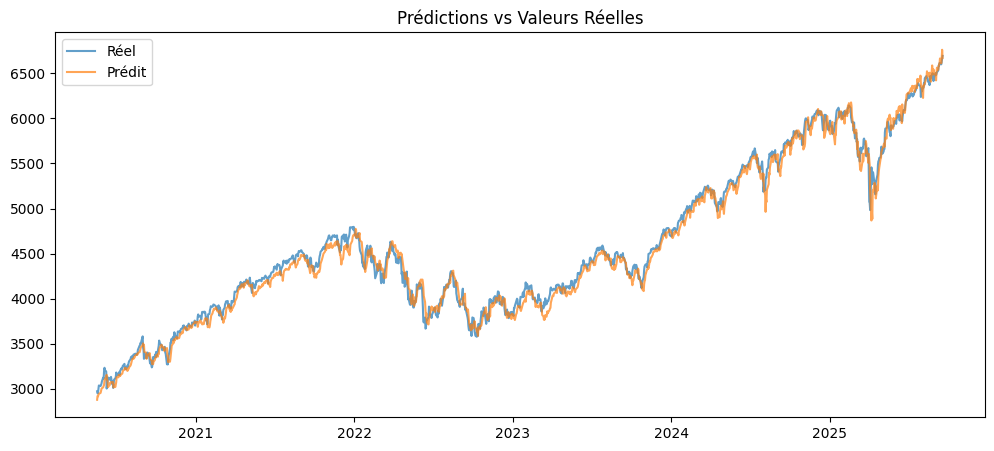

In [81]:
# Dénormaliser les prédictions
cible_idx = df.columns.get_loc('cible')
pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), cible_idx)), 
                                                        predictions, 
                                                        np.zeros((len(predictions), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]
y_test_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), cible_idx)), 
                                                          y_test.reshape(-1,1), 
                                                          np.zeros((len(y_test), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]

# Évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"MSE: {mean_squared_error(y_test_denorm, pred_denorm):.4f}")
print(f"MAE: {mean_absolute_error(y_test_denorm, pred_denorm):.4f}")
print(f"R²: {r2_score(y_test_denorm, pred_denorm):.4f}")

# Prédire le prochain point (future)
derniere_seq = data[-seq_len:].reshape(1, seq_len, df.shape[1])
next_pred = model.predict(derniere_seq)
next_pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((1, cible_idx)), 
                                                             next_pred, 
                                                             np.zeros((1, df.shape[1]-cible_idx-1))], axis=1))[0, cible_idx]
print(f"\nProchaine valeur prédite: {next_pred_denorm:.4f}")

# Visualisation (optionnel)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df.iloc[-len(y_test_denorm):].index, y_test_denorm, label='Réel', alpha=0.7)
plt.plot(df.iloc[-len(y_test_denorm):].index, pred_denorm, label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [72]:
len(y_test_denorm)

1342

In [74]:
len(df['cible'])

6719

In [78]:
df.iloc[3:10].index

DatetimeIndex(['1999-01-07', '1999-01-08', '1999-01-11', '1999-01-12',
               '1999-01-13', '1999-01-14', '1999-01-15'],
              dtype='datetime64[ns]', name='date', freq=None)

In [83]:
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.15.3
numpy: 2.3.1
matplotlib: 3.10.3
pandas: 2.3.0
statsmodels: 0.14.4
sklearn: 1.7.0


In [86]:
# # theano
# import theano
# print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)

tensorflow: 2.20.0
keras: 3.10.0


In [108]:
pd.DataFrame(df.columns)

,0
0,close
1,volume
2,high
3,low
4,pe
5,num_daily_adv_minus_decl
6,mov_avg_20d
7,best_eps
8,dvd_sh_last
9,rsi_3d


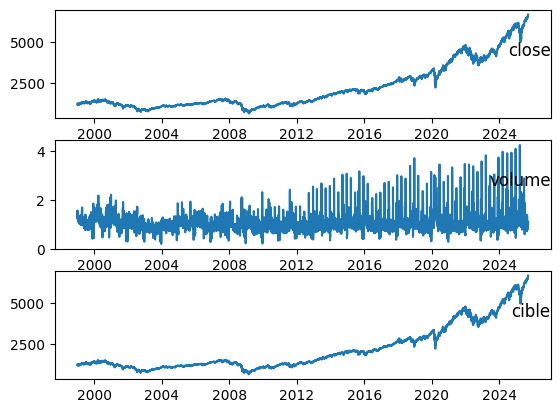

In [110]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = df.copy()
values = dataset.values
# specify columns to plot
groups = [0, 1, 29]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(df.index, values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()